In [29]:
# importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score 

import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')

## **1. Data Loading and Inspection**
---

In [30]:
# load data
df = pd.read_csv('diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [31]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50000 non-null  float64
 1   cut      50000 non-null  object 
 2   color    50000 non-null  object 
 3   clarity  50000 non-null  object 
 4   depth    50000 non-null  float64
 5   table    50000 non-null  float64
 6   price    50000 non-null  int64  
 7   x        50000 non-null  float64
 8   y        50000 non-null  float64
 9   z        50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [32]:
# summary statistics
df.describe()

,carat,depth,table,price,x,y,z
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.799444,61.753006,57.457830,3944.805440,5.734403,5.737956,3.541056
std,0.475173,1.431088,2.232092,3997.938105,1.123077,1.145579,0.707065
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2410.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5351.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## **2. Data Cleaning**  
---

In this section, we perform standard data cleaning practices to ensure the dataset is in a favourable condition for EDA and model training

### **2.1 Rename Columns**

In [33]:
# rename x, y, and z columns
df.rename(columns={'x': 'length(mm)', 'y': 'width(mm)', 'z':'depth(mm)'}, inplace=True)

df.head()

,carat,cut,color,clarity,depth,table,price,length(mm),width(mm),depth(mm)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [34]:
# check for NaN types
empty_vals = df.isna().sum()
print(empty_vals)

carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
length(mm)    0
width(mm)     0
depth(mm)     0
dtype: int64


### **2.2 Check and Handle Duplicates**

In [35]:
# check for duplicates 
df.duplicated().sum()

126

In [36]:
# remove duplicates
df_new = df.drop_duplicates()

### **2.3 Check and Handle Outliers**

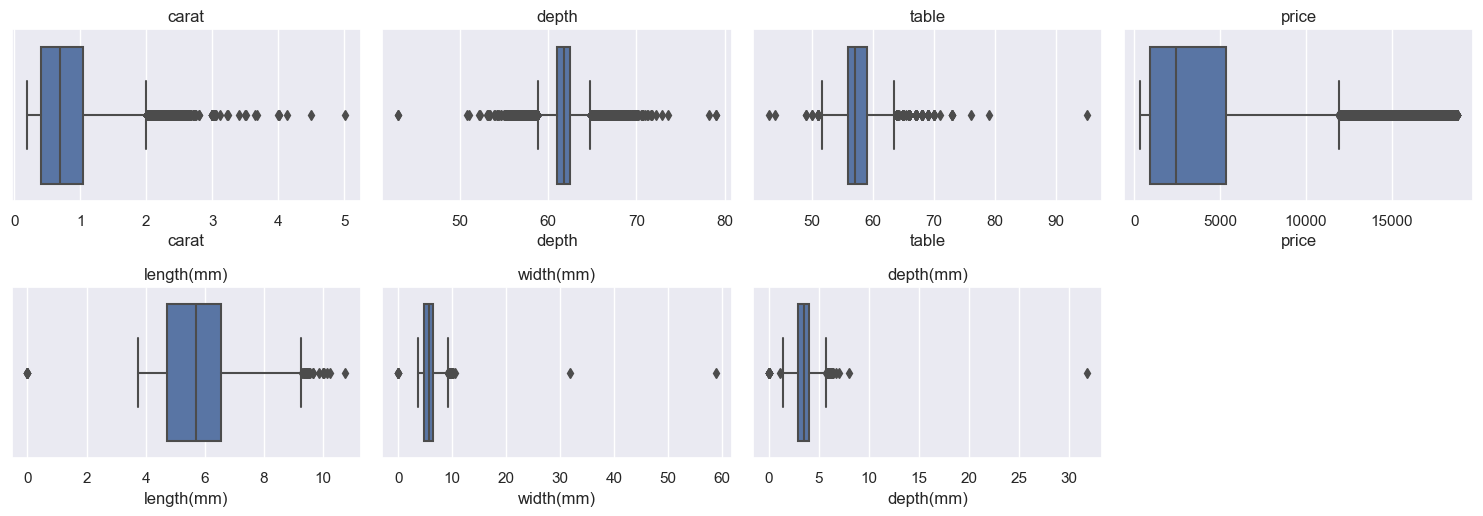

In [37]:
# boxplot of features
# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Create boxplots for numerical features
numerical_features = df_new.select_dtypes(include=['float', 'int']).columns.tolist()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [38]:
# function to check outliers

def remove_outliers(df):
    outlier_percentages = {}
    
    # Iterate over each numeric column
    for column in df.select_dtypes(include='number'):
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Calculate the percentage of outliers
        outlier_percentage = len(outliers) / len(df) * 100
        outlier_percentages[column] = outlier_percentage
        
        print(f"Column: {column}")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {outlier_percentage:.2f}%")
        
        # Remove outliers if they exceed 20%
        if outlier_percentage > 20:
            df[column] = df.loc[~((df[column] < lower_bound) | (df[column] > upper_bound)), column]
            print("Outliers removed due to exceeding 20% threshold.")
        else:
            print("No outliers removed.")
        
        print()
    
    return df, outlier_percentages

In [39]:
df_cleaned, outlier_percentages = remove_outliers(df_new)

Column: carat
Number of outliers: 1757
Percentage of outliers: 3.52%
No outliers removed.

Column: depth
Number of outliers: 2340
Percentage of outliers: 4.69%
No outliers removed.

Column: table
Number of outliers: 557
Percentage of outliers: 1.12%
No outliers removed.

Column: price
Number of outliers: 3255
Percentage of outliers: 6.53%
No outliers removed.

Column: length(mm)
Number of outliers: 31
Percentage of outliers: 0.06%
No outliers removed.

Column: width(mm)
Number of outliers: 28
Percentage of outliers: 0.06%
No outliers removed.

Column: depth(mm)
Number of outliers: 43
Percentage of outliers: 0.09%
No outliers removed.



In [40]:
df_cleaned.head()

,carat,cut,color,clarity,depth,table,price,length(mm),width(mm),depth(mm)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## **3. EDA**  
---  

In this section, we perform Exploratory Data Analysis where we look at various characteristics of the dataset such as distributions, correlations, etc.

### **3.1 Distributions**

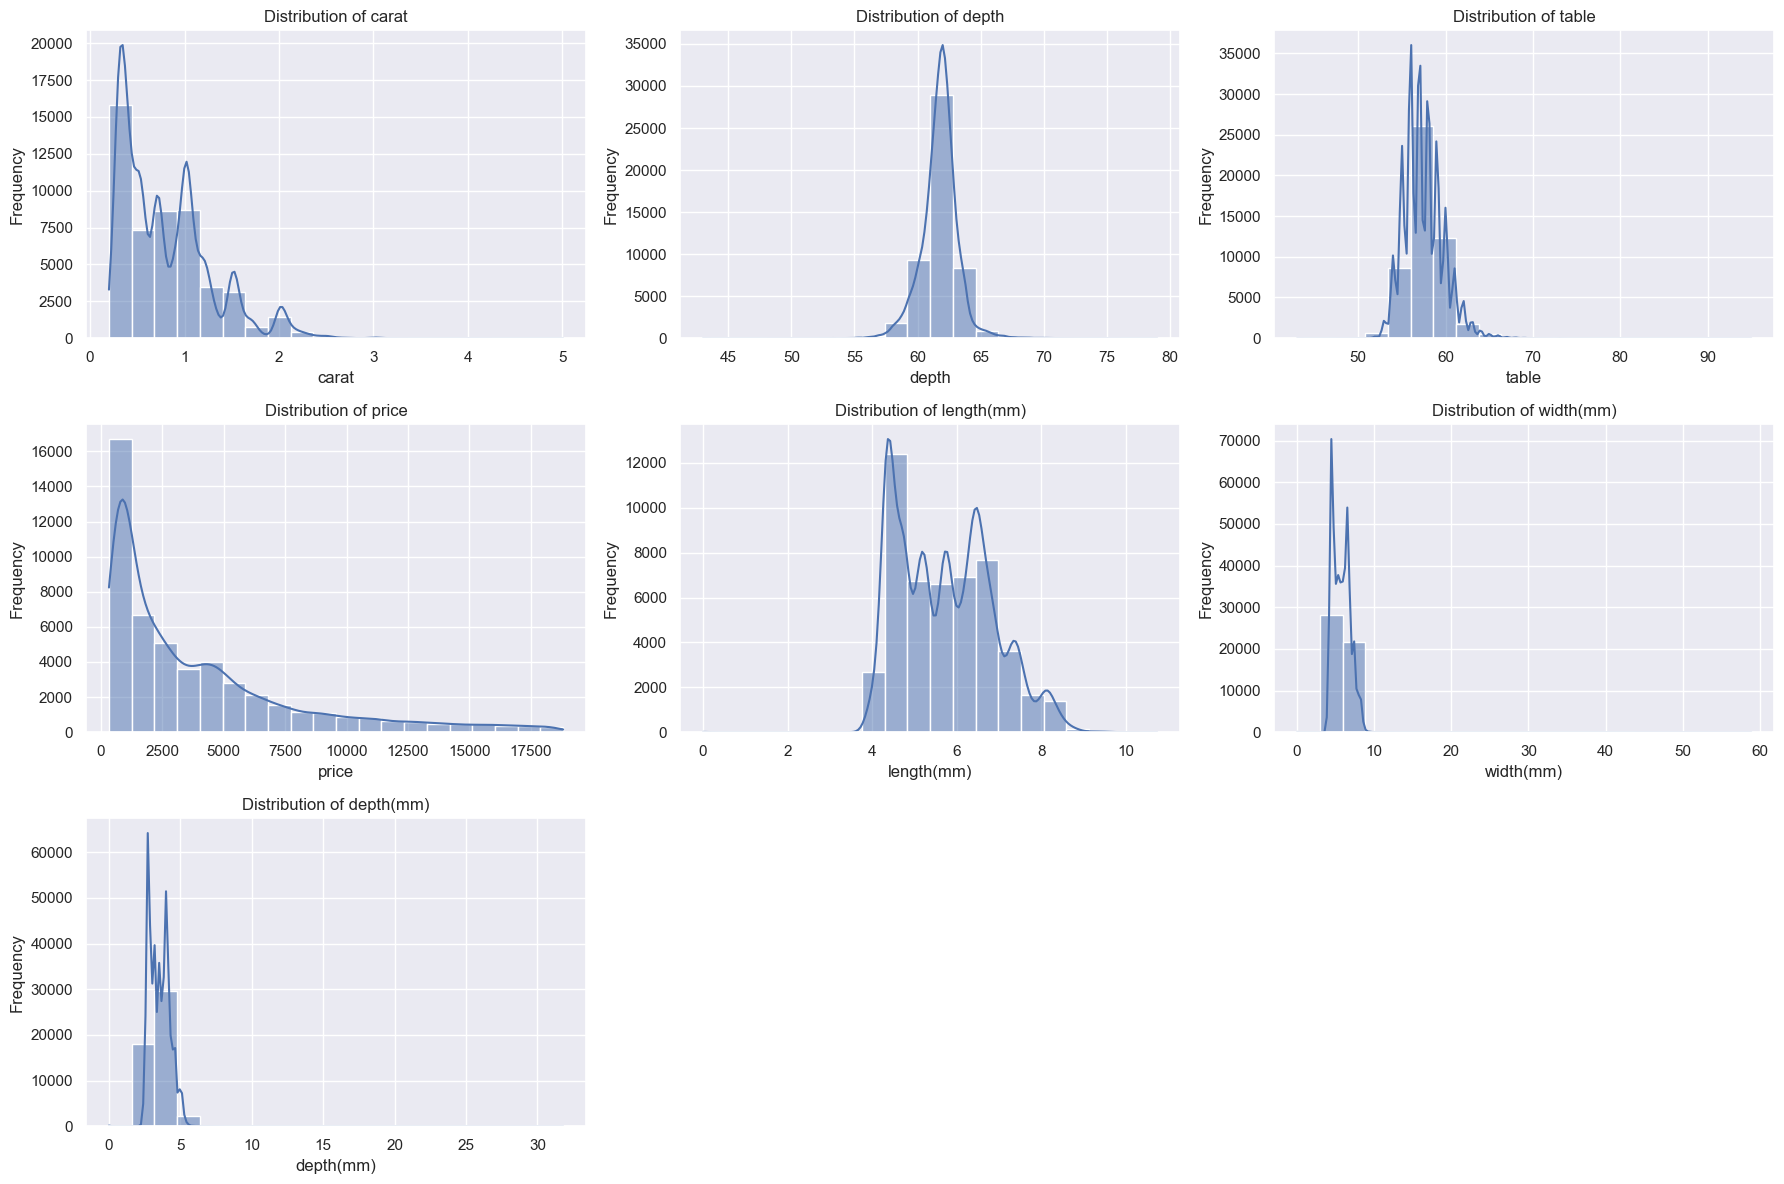

In [41]:
# create figure
plt.figure(figsize=(18,12))

# iterate through columns to plot and create subplots
for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_cleaned[column], kde=True, bins=20)
    # set title
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [42]:
numerical_features

['carat', 'depth', 'table', 'price', 'length(mm)', 'width(mm)', 'depth(mm)']

### **3.2 Correlations**

In [43]:
correlations = df_cleaned[numerical_features].corr()
correlations

,carat,depth,table,price,length(mm),width(mm),depth(mm)
carat,1.000000,0.027445,0.183153,0.921780,0.975102,0.950013,0.952655
depth,0.027445,1.000000,-0.294828,-0.013112,-0.025713,-0.029946,0.094030
table,0.183153,-0.294828,1.000000,0.129283,0.196560,0.184578,0.152385
price,0.921780,-0.013112,0.129283,1.000000,0.884844,0.864232,0.860791
length(mm),0.975102,-0.025713,0.196560,0.884844,1.000000,0.972881,0.970057
width(mm),0.950013,-0.029946,0.184578,0.864232,0.972881,1.000000,0.949898
depth(mm),0.952655,0.094030,0.152385,0.860791,0.970057,0.949898,1.000000


**Important Note:**  
With Price as the target column, features such as carat, length, width and depth of diamonds are strongly related/correlated with the price.  
i.e., strong positive correlations.

#### **3.2.1 Scatter Plots**

**A. Price vs Carat**

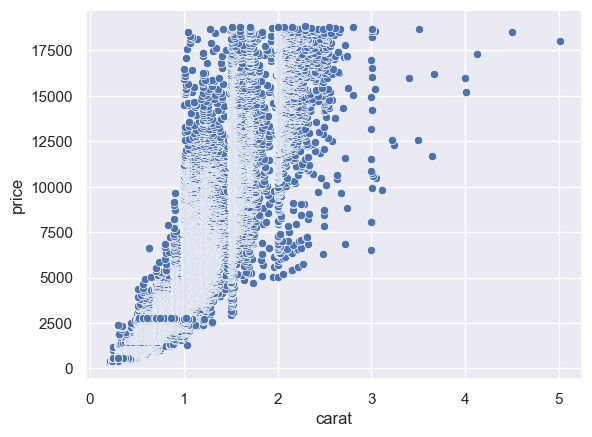

In [44]:
# creat scatter plot
sns.scatterplot(x = df_cleaned['carat'], y=df_cleaned['price'])
plt.show()

**B. Price vs Length**

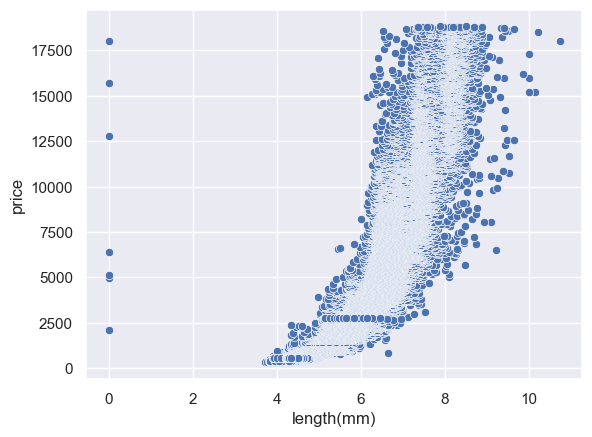

In [45]:
# creat scatter plot
sns.scatterplot(x = df_cleaned['length(mm)'], y=df_cleaned['price'])
plt.show()

**C. Price vs Width**

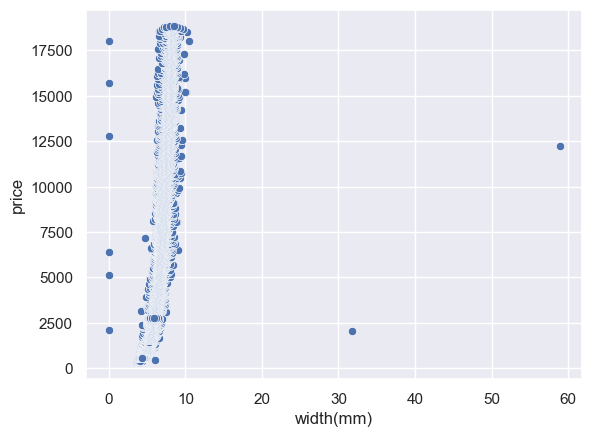

In [46]:
# creat scatter plot
sns.scatterplot(x = df_cleaned['width(mm)'], y=df_cleaned['price'])
plt.show()

**D. Price vs Depth**

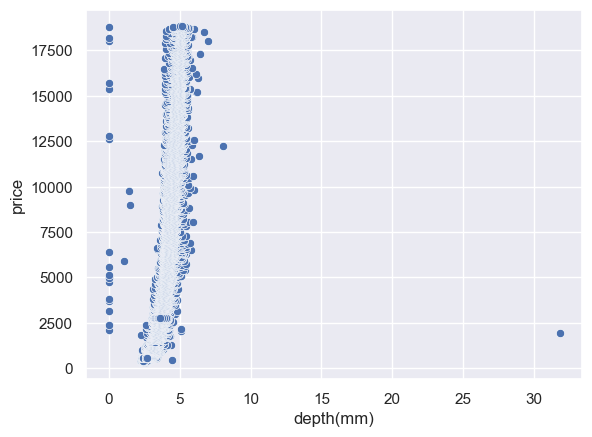

In [47]:
# creat scatter plot
sns.scatterplot(x = df_cleaned['depth(mm)'], y=df_cleaned['price'])
plt.xlabel('Depth of Diamond')
plt.show()

## **4. Data Preprocessing**  
---

In this section, we perform preprocessing steps such as label encoding, train_test_split, etc. to prepare the data for model training and evaluation.

### **4.1 Label Encoding**

this catet to nuem

In [48]:
# encode categorical features with Label Encoder

cat_features = df_cleaned.select_dtypes(include='object').columns.tolist()

# initialize labelEncoder
le = LabelEncoder()

# fit and transform label encoder on cat_features
for feature in cat_features:
    df_cleaned[feature] = le.fit_transform(df_cleaned[feature])

df_cleaned.head()

,carat,cut,color,clarity,depth,table,price,length(mm),width(mm),depth(mm)
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [49]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49874 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   carat       49874 non-null  float64
 1   cut         49874 non-null  int32  
 2   color       49874 non-null  int32  
 3   clarity     49874 non-null  int32  
 4   depth       49874 non-null  float64
 5   table       49874 non-null  float64
 6   price       49874 non-null  int64  
 7   length(mm)  49874 non-null  float64
 8   width(mm)   49874 non-null  float64
 9   depth(mm)   49874 non-null  float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 3.6 MB


### **4.2 Data Splitting**

In [50]:
# Split the data into features and target
X = df_cleaned.drop('price', axis=1)
y = df_cleaned['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **5. Model Training**  
---
`By use of Pipeline`



In [51]:
# Create the numerical and categorical transformers
num_transformer = MinMaxScaler()


num_features = X.select_dtypes(include=['float', 'int']).columns.tolist()


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features)
])

In [52]:
# Create the pipelines
pipelines = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'RandomForestRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ]),
    'GradientBoostingRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor())
    ]),
    'XGBRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor())
    ])
}


In [53]:
# Initialize variables to track the best model
best_model_name = None
best_model_pipeline = None
best_r2_score = -float('inf')  # Start with negative infinity for comparison
best_cv_r2_score = -float('inf')  # Start with negative infinity for comparison

# Train and evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = mse**0.5
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    cv_r2_score = scores.mean()
    
    print(f"{name}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse: .2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Cross-validation R2 Score: {cv_r2_score:.2f} (+/- {scores.std():.2f})\n")



# Check if this model is the best so far based on both R2 and cross-validation R2
if (r2 > best_r2_score) or (r2 == best_r2_score and cv_r2_score > best_cv_r2_score):
    best_r2_score = r2
    best_cv_r2_score = cv_r2_score
    best_model_name = name
    best_model_pipeline = pipeline


# Save the best model
if best_model_pipeline is not None:
    joblib.dump(best_model_pipeline, f'best_model_{best_model_name}.pkl')
    print(f"Best model '{best_model_name}' saved as 'best_model_{best_model_name}.pkl'")

LinearRegression:
Mean Squared Error: 1837123.99
Root Mean Squared Error:  1355.41
R2 Score: 0.88
Cross-validation R2 Score: -2.55 (+/- 5.34)

RandomForestRegressor:
Mean Squared Error: 310699.87
Root Mean Squared Error:  557.40
R2 Score: 0.98
Cross-validation R2 Score: 0.29 (+/- 0.42)

GradientBoostingRegressor:
Mean Squared Error: 461998.23
Root Mean Squared Error:  679.70
R2 Score: 0.97
Cross-validation R2 Score: 0.38 (+/- 0.36)

XGBRegressor:
Mean Squared Error: 310317.65
Root Mean Squared Error:  557.06
R2 Score: 0.98
Cross-validation R2 Score: 0.55 (+/- 0.18)

Best model 'XGBRegressor' saved as 'best_model_XGBRegressor.pkl'


In [54]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 49874 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   carat       49874 non-null  float64
 1   cut         49874 non-null  int32  
 2   color       49874 non-null  int32  
 3   clarity     49874 non-null  int32  
 4   depth       49874 non-null  float64
 5   table       49874 non-null  float64
 6   price       49874 non-null  int64  
 7   length(mm)  49874 non-null  float64
 8   width(mm)   49874 non-null  float64
 9   depth(mm)   49874 non-null  float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 3.6 MB


### **5.1. Interpretation Of Results**  
---

**Mean Squared Error (MSE)**

This metric indicates the average squared difference between the predicted and actual values. Lower values are better, suggesting that the predictions are closer to the actual values.  
In this case, both the XGBoost and Random Forest regressors have the lowest MSE, indicating they make more accurate predictions.  

**Root Mean Squared Error (RMSE)**  
This is the square root of MSE and provides an error metric in the same unit as the target variable. Again, lower values indicate better performance.   
The XGBoost regressor has the lowest RMSE, suggesting it has the best predictive performance.   


**$R^{2}$ Score**  
This metric indicates the proportion of variance in the target variable that is predictable from the independent variables. An R² score of 1 indicates perfect prediction,  
while a score of 0 indicates that the model does not explain any of the variance. The Random Forest and XGBoost regressors both have an R² score of 0.98,   
indicating they explain a very high proportion of the variance in the target variable.   


**Cross-Validation $R^{2}$ Score**  
This score assesses how well the model generalizes to unseen data. A higher value indicates better generalization.  

- Linear Regression has a negative CV R² score (-2.55), which suggests that it performs worse than a model that simply predicts the mean of the target variable.  
This indicates that the Linear Regression model is likely overfitting or not capturing the underlying patterns in the data.  

- Random Forest and Gradient Boosting have positive CV R² scores (0.29 and 0.38, respectively), indicating some level of generalization,   
but they are lower than expected given their training performance.  

- XGBoost has the highest CV R² score (0.55), suggesting it generalizes better to unseen data compared to the other models.




## **6. Analysis Section**

In this section, we explore feature importances in order to find the important features associated with the best model.

In [55]:
# Load the best model (XGBoost Regressor)
best_model_name = 'XGBRegressor' 
best_model_pipeline = joblib.load(f'best_model_{best_model_name}.pkl')

# Extract the XGBoost model from the pipeline
xgb_model = best_model_pipeline.named_steps['regressor']

# Get feature importances
importances = xgb_model.feature_importances_

# Get feature names from the pipeline
feature_names = best_model_pipeline.named_steps['preprocessor'].transformers[0][1].get_feature_names_out().tolist() + ['cut', 'color', 'clarity']

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances for XGBoost Regressor')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## **Conclusion**  
---

Based on the metrics above, the XGBoost Regressor appears to be the best-performing model overall, as it has the lowest MSE, RMSE, and the highest R² and Cross-validation R² scores.  
The Random Forest Regressor is also strong, but the Cross-validation R² indicates it may not generalize as well as XGBoost. The Gradient Boosting Regressor follows closely,   
while Linear Regression is the weakest performer among the models tested.  

The Adopted Model for this project is the **XGBoost Regressor.**